# Imports

In [1]:
import pandas as pd
import seaborn as sns
import sklearn as sk
import datetime as dt

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data Processing

## Selection of features

In [2]:
#Selection of existing relevant features per game : events that happened during each game
relevant_features = ['Date','HomeTeam','AwayTeam','IWH','IWD','IWA','FTR','FTHG','FTAG','HTHG','HTAG','HS','AS',
                     'HST','AST','HF','AF','HY','AY','HR','AR','HC','AC']

## Function for data processing of each season : creation of relevant features

In [3]:
def create_stat_dico(season: str, league: str) -> pd.DataFrame:
    
    """Compute statistics for a given season all the relevant statistics by going through each game
    
    Output a Dataframe of each game and each team statistics before the game
    
    Arguments : name of the season as a string, name of the league as a string
    """
    
    #stat_seasons is a 3-layer nested dico :
    # stats_season ---> dico of all clubs
    # club ---> dico of all week results
    # week ---> all stats for that week
    # stat ---> value for that specific game
     
    stats_season = {}
    file_name = '/Users/theophanegregoir/Desktop/BettingAI/Football_Data/European_Leagues/Entire_Data_' + league + '.xlsx'
    xls_file = pd.ExcelFile(file_name)
    table = xls_file.parse(season)[relevant_features].dropna(axis=0)
    
    ###Features that describe team before the game
    table['week'] = 0
    
    ###For Home Team (HT)
    table['HT_league_points'] = 0.0
    table['HT_average_goal_scored'] = 0.0
    table['HT_average_goal_conceeded'] = 0.0
    table['HT_average_goal_scored_half'] = 0.0
    table['HT_average_goal_conceeded_half'] = 0.0
    table['HT_average_yellow'] = 0.0
    table['HT_average_red'] = 0.0
    table['HT_average_shots'] = 0.0
    table['HT_average_shots_on_target'] = 0.0
    table['HT_average_shots_conceeded'] = 0.0
    table['HT_average_fouls_committed'] = 0.0
    table['HT_average_fouls_conceeded'] = 0.0
    
    ###For Away Team (AT)
    table['AT_league_points'] = 0.0
    table['AT_average_goal_scored'] = 0.0
    table['AT_average_goal_conceeded'] = 0.0
    table['AT_average_goal_scored_half'] = 0.0
    table['AT_average_goal_conceeded_half'] = 0.0
    table['AT_average_yellow'] = 0.0
    table['AT_average_red'] = 0.0
    table['AT_average_shots'] = 0.0
    table['AT_average_shots_on_target'] = 0.0
    table['AT_average_shots_conceeded'] = 0.0
    table['AT_average_fouls_committed'] = 0.0
    table['AT_average_fouls_conceeded'] = 0.0
    
    #Number of weeks available
    nb_weeks = int(len(table)/10)
    
    if season == '2019-2020':
        nb_weeks = int(len(table)/10) - 1
    
    #Getting unique list of club names for this season
    clubs = list(set(list(table['HomeTeam'])))

    #Creation of the dictionary of stats for each club       
    for c in clubs:
        
        #First layer of dict
        stats_season[c] = {}
        
        #Selection of the games where the club is involved
        isHome = table['HomeTeam'] == c
        isAway = table['AwayTeam'] == c
        selected = table.loc[isHome | isAway]
        stats_season[c]['games_index'] = list(selected.index)
        
        
        #Initialisation of week 0 for additive params
        stats_season[c][0] = {}
        stats_season[c][0]['league_points'] = 0.0
        stats_season[c][0]['goals_scored'] = 0.0
        stats_season[c][0]['goals_scored_half'] = 0.0
        stats_season[c][0]['goals_conceeded'] = 0.0
        stats_season[c][0]['goals_conceeded_half'] = 0.0
        stats_season[c][0]['yellow'] = 0.0
        stats_season[c][0]['red'] = 0.0
        stats_season[c][0]['fouls_conceeded'] = 0.0
        stats_season[c][0]['fouls_committed'] = 0.0
        stats_season[c][0]['shots'] = 0.0
        stats_season[c][0]['shots_on_target'] = 0.0
        stats_season[c][0]['shots_conceeded'] = 0.0
        
        #Going through all the weeks of the season
        for k in range(1,len(selected)):
            
            #Second layer of dict
            stats_season[c][k] = {}
            
            #Third layer of dict
            if selected['AwayTeam'][selected.index[k-1]] == c :
                stats_season[c][k]['is_Home'] = False
            else :
                stats_season[c][k]['is_Home'] = True
            
            #Modifying the dataframe to add the statistics before game (based on previous weeks) use as features for ML
            if stats_season[c][k]['is_Home']:
                table.at[selected.index[k-1],'week'] = k
                table.at[selected.index[k-1],'HT_league_points'] = stats_season[c][k-1]['league_points'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_scored'] = stats_season[c][k-1]['goals_scored'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_conceeded'] = stats_season[c][k-1]['goals_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_scored_half'] = stats_season[c][k-1]['goals_scored_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_conceeded_half'] =  stats_season[c][k-1]['goals_conceeded_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_shots'] = stats_season[c][k-1]['shots'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_shots_on_target'] = stats_season[c][k-1]['shots_on_target'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_shots_conceeded']= stats_season[c][k-1]['shots_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_yellow'] = stats_season[c][k-1]['yellow'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_red'] = stats_season[c][k-1]['red'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_fouls_committed'] = stats_season[c][k-1]['fouls_committed'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] / max(k-1.0,1.0)
            else :
                table.at[selected.index[k-1],'AT_league_points'] = stats_season[c][k-1]['league_points'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_scored'] = stats_season[c][k-1]['goals_scored'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_conceeded'] = stats_season[c][k-1]['goals_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_scored_half'] = stats_season[c][k-1]['goals_scored_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_conceeded_half'] =  stats_season[c][k-1]['goals_conceeded_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_shots'] = stats_season[c][k-1]['shots'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_shots_on_target'] = stats_season[c][k-1]['shots_on_target'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_shots_conceeded']= stats_season[c][k-1]['shots_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_yellow'] = stats_season[c][k-1]['yellow'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_red'] = stats_season[c][k-1]['red'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_fouls_committed'] = stats_season[c][k-1]['fouls_committed'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] / max(k-1.0,1.0)
            
            #Gathering the statistics of the game for the club for next games
            #League points
            if selected['FTR'][selected.index[k-1]] == "D" :
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 1.0
            elif selected['FTR'][selected.index[k-1]] == "A" and selected['AwayTeam'][selected.index[k-1]] == c:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 3.0
            elif selected['FTR'][selected.index[k-1]] == "H" and selected['HomeTeam'][selected.index[k-1]] == c:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 3.0
            else:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points']
            
            #Goals and shots
            if stats_season[c][k]['is_Home']:
                stats_season[c][k]['goals_scored'] = stats_season[c][k-1]['goals_scored'] + selected['FTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_scored_half'] = stats_season[c][k-1]['goals_scored_half'] + selected['HTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded'] = stats_season[c][k-1]['goals_conceeded'] + selected['FTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded_half'] = stats_season[c][k-1]['goals_conceeded_half'] + selected['HTAG'][selected.index[k-1]]
                stats_season[c][k]['shots'] = stats_season[c][k-1]['shots'] + selected['HS'][selected.index[k-1]]
                stats_season[c][k]['shots_on_target'] = stats_season[c][k-1]['shots_on_target'] + selected['HST'][selected.index[k-1]]
                stats_season[c][k]['shots_conceeded'] = stats_season[c][k-1]['shots_conceeded'] + selected['AS'][selected.index[k-1]]
            else :
                stats_season[c][k]['goals_scored'] = stats_season[c][k-1]['goals_scored'] + selected['FTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_scored_half'] = stats_season[c][k-1]['goals_scored_half'] + selected['HTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded'] = stats_season[c][k-1]['goals_conceeded'] + selected['FTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded_half'] = stats_season[c][k-1]['goals_conceeded_half'] + selected['HTHG'][selected.index[k-1]]
                stats_season[c][k]['shots'] = stats_season[c][k-1]['shots'] + selected['AS'][selected.index[k-1]]
                stats_season[c][k]['shots_on_target'] = stats_season[c][k-1]['shots_on_target'] + selected['AST'][selected.index[k-1]]
                stats_season[c][k]['shots_conceeded'] = stats_season[c][k-1]['shots_conceeded'] + selected['HS'][selected.index[k-1]]
            
            #Fouls and cards
            if stats_season[c][k]['is_Home']:
                stats_season[c][k]['yellow'] = stats_season[c][k-1]['yellow'] + selected['HY'][selected.index[k-1]]
                stats_season[c][k]['red'] = stats_season[c][k-1]['red'] + selected['HR'][selected.index[k-1]]
                stats_season[c][k]['fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] + selected['AF'][selected.index[k-1]]
                stats_season[c][k]['fouls_committed'] = stats_season[c][k-1]['fouls_committed'] + selected['HF'][selected.index[k-1]]
            else:
                stats_season[c][k]['yellow'] = stats_season[c][k-1]['yellow'] + selected['AY'][selected.index[k-1]]
                stats_season[c][k]['red'] = stats_season[c][k-1]['red'] + selected['AR'][selected.index[k-1]]
                stats_season[c][k]['fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] + selected['HF'][selected.index[k-1]]
                stats_season[c][k]['fouls_committed'] = stats_season[c][k-1]['fouls_committed'] + selected['AF'][selected.index[k-1]]
    
    valid = table['week'] > 5
    
    return(table[valid])

## Processing selected data

In [4]:
#List of all features created after processing
processed_features = ['week', 'HT_league_points', 'HT_average_goal_scored',
           'HT_average_goal_conceeded', 'HT_average_goal_scored_half',
           'HT_average_goal_conceeded_half', 'HT_average_yellow', 'HT_average_red',
           'HT_average_shots', 'HT_average_shots_on_target',
           'HT_average_shots_conceeded', 'HT_average_fouls_committed',
           'HT_average_fouls_conceeded', 'AT_league_points',
           'AT_average_goal_scored', 'AT_average_goal_conceeded',
           'AT_average_goal_scored_half', 'AT_average_goal_conceeded_half',
           'AT_average_yellow', 'AT_average_red', 'AT_average_shots',
           'AT_average_shots_on_target', 'AT_average_shots_conceeded',
           'AT_average_fouls_committed', 'AT_average_fouls_conceeded','FTR','IWH','IWD','IWA']

#Leagues selected
chosen_leagues = ['PL', 'SerieA','Bundesliga']

#Seasons selected
start_year = 2010
end_year = 2020

data_seasons = {}

for i in range(start_year,end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    data_seasons[season] = {}
    
    for league in chosen_leagues:
        
        print("Processing " + league + ' ' + str(i) + '-' + str(i+1))

        table = create_stat_dico(season, league)

        full_table_add = table[processed_features]
        
        data_seasons[season][league] = full_table_add
 

Processing PL 2010-2011
Processing SerieA 2010-2011
Processing Bundesliga 2010-2011
Processing PL 2011-2012
Processing SerieA 2011-2012
Processing Bundesliga 2011-2012
Processing PL 2012-2013
Processing SerieA 2012-2013
Processing Bundesliga 2012-2013
Processing PL 2013-2014
Processing SerieA 2013-2014
Processing Bundesliga 2013-2014
Processing PL 2014-2015
Processing SerieA 2014-2015
Processing Bundesliga 2014-2015
Processing PL 2015-2016
Processing SerieA 2015-2016
Processing Bundesliga 2015-2016
Processing PL 2016-2017
Processing SerieA 2016-2017
Processing Bundesliga 2016-2017
Processing PL 2017-2018
Processing SerieA 2017-2018
Processing Bundesliga 2017-2018
Processing PL 2018-2019
Processing SerieA 2018-2019
Processing Bundesliga 2018-2019
Processing PL 2019-2020
Processing SerieA 2019-2020
Processing Bundesliga 2019-2020


## Visualize data final format

In [5]:
#Visualize the format of dataframe
full_table_add

,week,HT_league_points,HT_average_goal_scored,HT_average_goal_conceeded,HT_average_goal_scored_half,HT_average_goal_conceeded_half,HT_average_yellow,HT_average_red,HT_average_shots,HT_average_shots_on_target,...,AT_average_red,AT_average_shots,AT_average_shots_on_target,AT_average_shots_conceeded,AT_average_fouls_committed,AT_average_fouls_conceeded,FTR,IWH,IWD,IWA
45,6,0.800000,1.000000,2.000000,0.400000,1.400000,1.200000,0.600000,11.400000,3.000000,...,0.000000,16.600000,5.400000,12.200000,13.600000,10.400000,A,3.00,3.50,2.30
46,6,1.000000,1.400000,2.200000,1.000000,0.800000,2.000000,0.200000,10.000000,3.800000,...,0.000000,17.200000,6.400000,8.600000,9.200000,10.600000,A,4.55,4.50,1.63
47,6,1.000000,0.800000,1.400000,0.200000,1.000000,1.800000,0.000000,11.800000,3.000000,...,0.000000,16.000000,5.600000,15.000000,14.000000,14.800000,A,2.60,3.50,2.60
48,6,0.600000,1.000000,3.000000,0.600000,0.800000,2.200000,0.000000,15.000000,4.200000,...,0.000000,13.000000,4.800000,9.800000,11.600000,14.000000,A,2.90,3.55,2.35
49,6,0.200000,1.200000,2.800000,1.000000,1.200000,2.400000,0.000000,11.800000,4.000000,...,0.000000,16.800000,7.000000,10.000000,10.200000,14.200000,A,15.50,9.00,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,23,1.181818,1.227273,1.727273,0.454545,0.681818,2.181818,0.136364,10.136364,3.227273,...,0.142857,12.619048,4.476190,14.000000,13.952381,12.857143,A,2.40,3.40,2.90
200,22,2.000000,2.000000,1.142857,0.904762,0.428571,2.476190,0.095238,13.571429,5.666667,...,0.000000,13.136364,4.727273,14.409091,10.818182,12.500000,D,1.65,4.30,4.75
202,23,1.636364,1.454545,1.227273,0.454545,0.318182,1.727273,0.045455,12.000000,4.272727,...,0.045455,16.227273,6.681818,10.227273,10.409091,10.772727,A,4.15,3.95,1.80
203,23,1.818182,1.727273,1.318182,1.045455,0.636364,1.727273,0.272727,16.090909,6.636364,...,0.090909,11.454545,4.318182,14.636364,10.681818,11.318182,H,1.48,4.70,6.10


# Defining train and test datasets

## Training dataset

In [6]:
#Selection of seasons used to train
train_start_year = 2010
train_end_year = 2017

train_df = pd.DataFrame(columns = processed_features)

for i in range(train_start_year,train_end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    for league in chosen_leagues:
        
        table = data_seasons[season][league]
        
        two_concat = [train_df, table]
        
        train_df = pd.concat(two_concat)
        

print("The model will train on " + str(len(train_df)) + " matches !")

#Choice of the features
features = ['HT_league_points', 'HT_average_goal_scored',
       'HT_average_goal_conceeded', 'HT_average_goal_scored_half',
       'HT_average_goal_conceeded_half','HT_average_red',
       'HT_average_shots', 'HT_average_shots_on_target',
       'HT_average_shots_conceeded', 'AT_league_points',
       'AT_average_goal_scored', 'AT_average_goal_conceeded',
       'AT_average_goal_scored_half', 'AT_average_goal_conceeded_half',
       'AT_average_red', 'AT_average_shots',
       'AT_average_shots_on_target', 'AT_average_shots_conceeded']

n_features = len(features)

train_x = train_df[features]

train_y = train_df['FTR']


The model will train on 6221 matches !


## Testing dataset

In [7]:
#Selection of seasons used to test
test_start_year = 2017
test_end_year = 2020

test_df = pd.DataFrame(columns = processed_features)

for i in range(test_start_year,test_end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    for league in chosen_leagues:
        
        table = data_seasons[season][league]
        
        two_concat = [test_df, table]
        
        test_df = pd.concat(two_concat)

#Choice of the features (we first delete the odds)
test_x = test_df[features]

#Labels for training
test_y = test_df['FTR']

print("The model will test on " + str(len(test_df)) + " matches !")

The model will test on 2332 matches !


# Let's apply classical ML algorithms

## Importing models

In [8]:
#Dealing with format and metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

#Classical classifiers
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

#Ensemblist models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

#Neural Networks
from sklearn.neural_network import MLPClassifier

## Training and testing : getting probabilities for test data

In [9]:
# Dealing with parameters
C = 5.0

# Create different classifiers.
classifiers = {
    'L1 logistic': LogisticRegression(C=1.0, penalty='l1',
                                      solver='saga', tol=0.0001,
                                      multi_class='multinomial',
                                      max_iter=10000),
    'L2 logistic (Multinomial)': LogisticRegression(C=C, penalty='l2',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                                    max_iter=10000),
    'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                            max_iter=10000),
#    'Decision Tree' : DecisionTreeClassifier(criterion='gini', 
#                                            splitter='best', 
#                                             max_depth=None, 
#                                             min_samples_split=2),
    'Random Forest': RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=25, 
                                            min_samples_split=2, min_samples_leaf=1, 
                                            min_weight_fraction_leaf=0.0, max_features='auto', 
                                            max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                            min_impurity_split=None, bootstrap=True, oob_score=False, 
                                            n_jobs=None, random_state=None),
#    'MLP' : MLPClassifier(hidden_layer_sizes=(100,100), activation='relu', solver='adam', alpha=0.0001, 
#                          batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
#                          max_iter=1000, shuffle=True, random_state=None, tol=0.00001, verbose=False, 
#                          warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
#                          validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
#                          n_iter_no_change=10),
#    'SVM' : svm.NuSVC(nu=0.5, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True,
#                      probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
#                      max_iter=-1, decision_function_shape='ovr', random_state=None)
}

n_classifiers = len(classifiers)

results = {}

for index, (name, classifier) in enumerate(classifiers.items()):
    print("Training " + name + "...")
    classifier.fit(train_x, train_y)

    y_pred = classifier.predict(test_x)
    accuracy = accuracy_score(test_y, y_pred)
    print("Accuracy (test) for %s: %0.1f%% " % (name, accuracy * 100))
    
    #Calculate probabilities:
    probas = classifier.predict_proba(test_x)
    
    #store them in a dict
    results[name] = probas


Training L1 logistic...
Accuracy (test) for L1 logistic: 53.5% 
Training L2 logistic (Multinomial)...
Accuracy (test) for L2 logistic (Multinomial): 53.5% 
Training L2 logistic (OvR)...
Accuracy (test) for L2 logistic (OvR): 53.5% 
Training Random Forest...
Accuracy (test) for Random Forest: 52.8% 


# Function to optimize

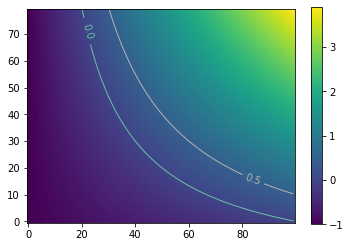

In [10]:
from numpy import arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
def z_func(x,y):
    return (x*y - 1)
 
prob = arange(0.0,1.0,0.01)
odd = arange(1.0,5.0,0.05)
X,Y = meshgrid(prob, odd) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid

im = imshow(Z,origin = 'lower') # drawing the function

# adding the Contour lines with labels
cset = contour(Z,[0.0, 0.5],linewidths=1,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)

colorbar(im) # adding the colobar on the right

show()

# Performance analysis

## Calculations of expected gain for each result

In [11]:
performance_df = test_df[['FTR','IWA','IWD','IWH']]
performance_df['P(A)']= pd.DataFrame(data = results['L1 logistic'][:,0], columns = ['P(A)'])
performance_df['E(A)']= performance_df['P(A)'] * performance_df['IWA'] - 1.0
performance_df['P(D)']= pd.DataFrame(data = results['L1 logistic'][:,1], columns = ['P(D)'])
performance_df['E(D)']= performance_df['P(D)'] * performance_df['IWD'] - 1.0
performance_df['P(H)']= pd.DataFrame(data = results['L1 logistic'][:,2], columns = ['P(H)'])
performance_df['E(H)']= performance_df['P(H)'] * performance_df['IWH'] - 1.0
performance_df

,FTR,IWA,IWD,IWH,P(A),E(A),P(D),E(D),P(H),E(H)
50,D,3.40,3.25,2.20,0.206862,-0.296669,0.326484,0.061074,0.466653,0.026638
51,H,5.30,3.80,1.65,0.098140,-0.479857,0.234900,-0.107380,0.666960,0.100484
52,A,2.00,3.40,3.80,0.156227,-0.687547,0.262169,-0.108626,0.581604,1.210097
53,H,18.00,7.50,1.15,0.278415,4.011474,0.286431,1.148230,0.435154,-0.499573
54,A,1.75,3.60,4.80,0.326697,-0.428279,0.282169,0.015808,0.391134,0.877442
...,...,...,...,...,...,...,...,...,...,...
199,A,2.90,3.40,2.40,0.185694,-0.461487,0.226548,-0.229737,0.587758,0.410619
200,D,4.75,4.30,1.65,0.069645,-0.669184,0.166687,-0.283245,0.763667,0.260051
202,A,1.80,3.95,4.15,0.309590,-0.442738,0.283361,0.119275,0.407049,0.689254
203,H,6.10,4.70,1.48,0.723444,3.413009,0.179841,-0.154745,0.096714,-0.856863


## Selection of results to bet on and their actual performances

In [12]:
#Floor and cap on expected gain to consider
floor = 1.0
cap = 4.0

### Draws performance

In [13]:
#Selection of the draws
draw_floor = performance_df['E(D)'] > floor
draw_cap = performance_df['E(D)'] < cap
selected_draw = performance_df[draw_floor & draw_cap]

#Computation of actual gains on draws
selected_draw['Gain'] = 0.0
is_Draw = selected_draw['FTR'] == 'D'
not_Draw = selected_draw['FTR'] != 'D'
selected_draw.loc[not_Draw, 'Gain'] = -1.0
selected_draw.loc[is_Draw, 'Gain'] = selected_draw.loc[is_Draw,'IWD'] - 1.0
selected_draw

,FTR,IWA,IWD,IWH,P(A),E(A),P(D),E(D),P(H),E(H),Gain
53,H,18.00,7.5,1.15,0.278415,4.011474,0.286431,1.148230,0.435154,-0.499573,-1.0
63,H,15.00,7.5,1.17,0.317980,3.769700,0.287128,1.153462,0.394892,-0.537977,-1.0
83,H,18.00,7.5,1.15,0.439444,6.909992,0.298037,1.235279,0.262519,-0.698103,-1.0
138,H,15.00,7.5,1.17,0.449416,5.741246,0.292433,1.193247,0.258151,-0.697964,-1.0
149,H,20.00,9.0,1.12,0.555820,10.116396,0.249249,1.243241,0.194931,-0.781677,-1.0
214,H,20.00,9.0,1.12,0.231188,3.623763,0.242127,1.179139,0.526685,-0.410113,-1.0
245,H,18.00,7.5,1.15,0.348192,5.267462,0.298431,1.238230,0.353377,-0.593616,-1.0
341,H,13.00,7.0,1.20,0.273864,2.560232,0.303885,1.127192,0.422251,-0.493298,-1.0
363,D,20.00,9.0,1.12,0.148947,1.978938,0.236682,1.130136,0.614371,-0.311904,8.0
367,H,20.00,9.0,1.12,0.258942,4.178850,0.289915,1.609238,0.451142,-0.494721,-1.0


### Aways performance

In [14]:
#Selection of the aways
away_floor = performance_df['E(A)'] > floor
away_cap = performance_df['E(A)'] < cap
selected_away = performance_df[away_floor & away_cap]

#Computation of actual gains on aways
selected_away['Gain'] = 0.0
is_Away = selected_away['FTR'] == 'A'
not_Away = selected_away['FTR'] != 'A'
selected_away.loc[not_Away, 'Gain'] = -1.0
selected_away.loc[is_Away, 'Gain'] = selected_away.loc[is_Away,'IWA'] - 1.0
selected_away

,FTR,IWA,IWD,IWH,P(A),E(A),P(D),E(D),P(H),E(H),Gain
63,H,15.0,7.50,1.17,0.317980,3.769700,0.287128,1.153462,0.394892,-0.537977,-1.0
64,H,2.7,3.15,2.70,0.757584,1.045478,0.151303,-0.523396,0.091113,-0.753995,-1.0
75,H,11.0,6.00,1.25,0.327275,2.600021,0.297786,0.786715,0.374940,-0.531326,-1.0
78,D,4.5,3.60,1.80,0.710527,2.197374,0.204068,-0.265355,0.085405,-0.846272,-1.0
81,H,8.0,5.30,1.35,0.615398,3.923184,0.225274,0.193953,0.159328,-0.784907,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
187,D,6.5,4.80,1.45,0.326114,1.119742,0.272790,0.309393,0.401096,-0.418411,-1.0
188,H,6.5,4.80,1.45,0.615923,3.003498,0.216546,0.039423,0.167531,-0.757080,-1.0
189,D,3.5,3.65,2.05,0.742398,1.598392,0.175041,-0.361099,0.082561,-0.830750,-1.0
192,H,8.5,6.00,1.30,0.364996,2.102469,0.264717,0.588300,0.370287,-0.518627,-1.0


### Homes performance

In [15]:
#Selection of the homes
home_floor = performance_df['E(H)'] > floor
home_cap = performance_df['E(H)'] < cap
selected_home = performance_df[home_floor & home_cap]

#Computation of actual gains on aways
selected_home['Gain'] = 0.0
is_Home = selected_home['FTR'] == 'H'
not_Home = selected_home['FTR'] != 'H'
selected_home.loc[not_Home, 'Gain'] = -1.0
selected_home.loc[is_Home, 'Gain'] = selected_home.loc[is_Home,'IWH'] - 1.0
selected_home

,FTR,IWA,IWD,IWH,P(A),E(A),P(D),E(D),P(H),E(H),Gain
52,A,2.00,3.40,3.80,0.156227,-0.687547,0.262169,-0.108626,0.581604,1.210097,-1.00
62,A,1.45,4.50,7.00,0.184800,-0.732040,0.284244,0.279099,0.530956,2.716691,-1.00
69,D,1.75,3.75,4.60,0.265753,-0.534933,0.270438,0.014141,0.463810,1.133525,-1.00
71,H,1.40,4.80,7.50,0.329304,-0.538975,0.308022,0.478505,0.362674,1.720057,6.50
76,H,1.75,3.70,4.60,0.053538,-0.906309,0.179954,-0.334170,0.766508,2.525937,3.60
...,...,...,...,...,...,...,...,...,...,...,...
153,H,2.55,3.50,2.65,0.056405,-0.856167,0.173191,-0.393831,0.770404,1.041570,1.65
154,A,1.67,4.20,4.60,0.109920,-0.816433,0.199480,-0.162186,0.690600,2.176761,-1.00
174,D,2.05,3.70,3.35,0.054799,-0.887662,0.156756,-0.420003,0.788445,1.641291,-1.00
179,A,2.00,3.80,3.45,0.087196,-0.825608,0.185994,-0.293223,0.726810,1.507495,-1.00
